In [1]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1.axes_divider import make_axes_locatable
import pandas as pd
import seaborn as sns
import torch
import torch.nn as nn
import torch.nn.functional as F

import model, utils, inference

from importlib import reload
reload(model)

<module 'model' from '/storage/coda1/p-awu36/0/cli726/vis/pohawkes/model.py'>

In [3]:
## arguments
method_list = np.array(['VI', 'CHIVI', 'VBIS', 'VIS'])
trial_list = np.arange(10)
seed_list = np.arange(10)

In [4]:
data = pd.read_pickle('data.pkl')

In [4]:
df_list = []
for method in method_list:
    for trial in trial_list:
        for seed in seed_list:
            try:
                df_temp = pd.read_csv(f'csv/{method}_{trial}_{seed}.csv')
                df_temp['weight error'] = (data.at[trial, 'gen_model']['linear.weight'] - torch.load(f'model/{method}_{trial}_{seed}_inf.pt')['linear.weight']).abs().mean().item()
                df_temp['bias error'] = (data.at[trial, 'gen_model']['linear.bias'] - torch.load(f'model/{method}_{trial}_{seed}_inf.pt')['linear.bias']).abs().mean().item()
                df_temp['method'] = method
                df_temp['trial'] = trial
                df_temp['seed'] = seed
                df_list.append(df_temp)
            except:
                print(method, trial)

df = pd.concat(df_list, ignore_index=True)

In [5]:
df_1 = df.groupby(['seed', 'method']).mean().reset_index()

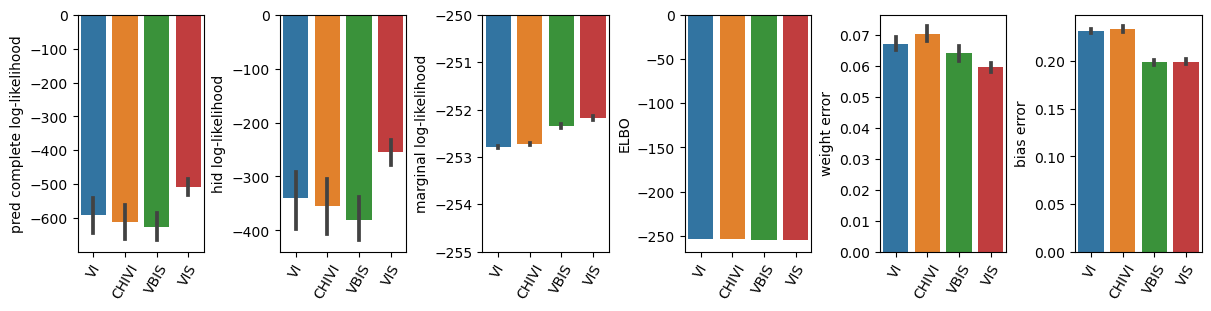

In [7]:
fig, axs = plt.subplots(1, 6, figsize=(12, 3), constrained_layout=True, sharex=True)

ax = sns.barplot(x='method', y='pred complete log-likelihood', data=df_1, ax=axs[0], order=method_list)
ax.set(xlabel=None)
# ax.get_legend().remove()
ax.tick_params(axis='x', rotation=60)

ax = sns.barplot(x='method', y='hid log-likelihood', data=df_1, ax=axs[1], order=method_list)
ax.set(xlabel=None)
# ax.get_legend().remove()
ax.tick_params(axis='x', rotation=60)

ax = sns.barplot(x='method', y='marginal log-likelihood', data=df_1, ax=axs[2], order=method_list)
ax.set(xlabel=None)
# ax.get_legend().remove()
ax.tick_params(axis='x', rotation=60)
ax.set_ylim(-255, -250)

ax = sns.barplot(x='method', y='ELBO', data=df_1, ax=axs[3], order=method_list)
ax.set(xlabel=None)
# ax.get_legend().remove()
ax.tick_params(axis='x', rotation=60)

ax = sns.barplot(x='method', y='weight error', data=df_1, ax=axs[4], order=method_list)
ax.set(xlabel=None)
# ax.get_legend().remove()
ax.tick_params(axis='x', rotation=60)

ax = sns.barplot(x='method', y='bias error', data=df_1, ax=axs[5], order=method_list)
ax.set(xlabel=None)
# ax.get_legend().remove()
ax.tick_params(axis='x', rotation=60)
# ax.get_legend().remove()
# fig.savefig(f'{folder}_metric.pdf')

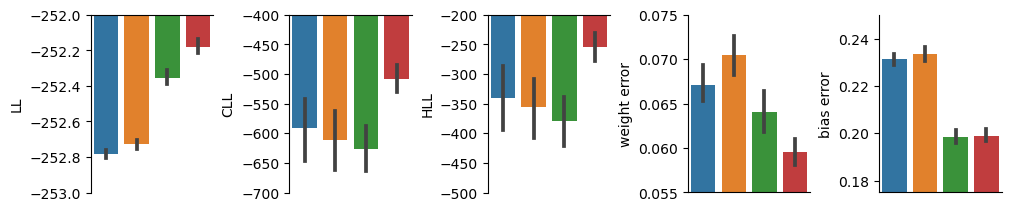

In [69]:
## likelihood and errors
fig, axs = plt.subplots(1, 5, figsize=(10, 2), constrained_layout=True)
ax = sns.barplot(x='method', y='marginal log-likelihood', data=df_1, ax=axs[0], order=method_list)
ax.set_ylim(-253, -252)
ax.set(xlabel=None)
ax.set_ylabel('LL')
ax.spines['bottom'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.xaxis.set_visible(False)

ax = sns.barplot(x='method', y='pred complete log-likelihood', data=df_1, ax=axs[1], order=method_list)
ax.set_ylim(-700, -400)
ax.set(xlabel=None)
ax.set_ylabel('CLL')
ax.spines['bottom'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.xaxis.set_visible(False)

ax = sns.barplot(x='method', y='hid log-likelihood', data=df_1, ax=axs[2], order=method_list)
ax.set_ylim(-500, -200)
ax.set(xlabel=None)
ax.set_ylabel('HLL')
ax.spines['bottom'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.xaxis.set_visible(False)

ax = sns.barplot(x='method', y='weight error', data=df_1, ax=axs[3], order=method_list)
ax.set_ylim(0.055, 0.075)
ax.set(xlabel=None)
ax.set_ylabel('weight error')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.xaxis.set_visible(False)

ax = sns.barplot(x='method', y='bias error', data=df_1, ax=axs[4], order=method_list)
ax.set_ylim(0.175, 0.25)
ax.set(xlabel=None)
ax.set_ylabel('bias error')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.xaxis.set_visible(False)

fig.savefig('poglm_bar.pdf', bbox_inches='tight', transparent=True)

In [6]:
trial = 0
seed = 0
sample = 0

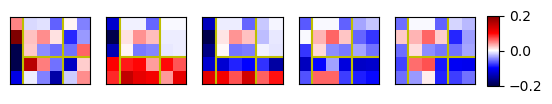

In [24]:
def visualize_linear(w, ax, v=0.2):
    w = torch.cat((w['linear.bias'][:, None], w['linear.weight']), dim=1)
    im = ax.matshow(w, cmap='seismic', vmin=-v, vmax=v)
    ax.tick_params(left=False, top=False, bottom=False, labelleft=False, labeltop=False)
    ax.hlines(y=[2.5], xmin=[0.5], xmax=[5.5], colors='y')
    ax.vlines(x=[0.5, 3.5], ymin=[-0.5, -0.5], ymax=[4.5, 4.5], colors='y')
    return im


fig, axs = plt.subplots(1, 5, figsize=(6, 2))
visualize_linear(data.at[trial, 'gen_model'], axs[0])
for i, method in enumerate(method_list):
    w = torch.load(f'model/{method}_{trial}_{seed}_inf.pt')
    im = visualize_linear(w, axs[i+1])

fig.colorbar(im, cax=fig.add_axes([0.92, 0.32, 0.02, 0.35]), orientation='vertical')

fig.savefig('poglm_w.pdf', bbox_inches='tight', transparent=True)

In [12]:
decay = 5
dt = 0.05
window_size = 5
n_neurons = 5
n_vis_neurons = 3
basis = utils.exp_basis(decay, window_size, dt*window_size)
T = 5

In [13]:
spikes = data.at[trial, 'spikes_list_test'][sample]
convolved_spikes = data.at[trial, 'convolved_spikes_list_test'][sample]
firing_rates = data.at[trial, 'firing_rates_list_test'][sample]

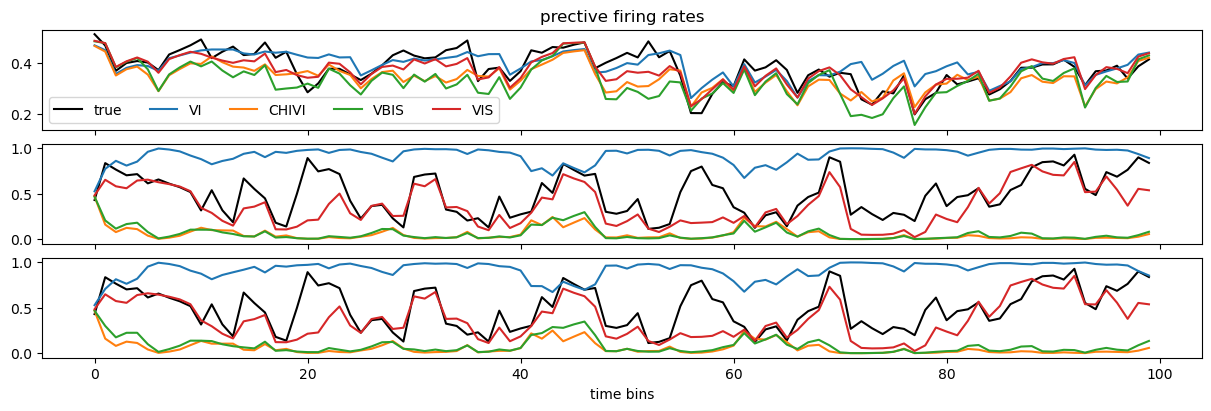

In [90]:
spikes = data.at[trial, 'spikes_list_test'][sample]
convolved_spikes = data.at[trial, 'convolved_spikes_list_test'][sample]
firing_rates = data.at[trial, 'firing_rates_list_test'][sample]


fig, axs = plt.subplots(3, 1, figsize=(12, 4), constrained_layout=True, sharex=True)
vis_neuron = 0
hid_neuron = 3

with torch.no_grad():
    axs[0].plot(firing_rates[:, vis_neuron], 'k', label='true')
    axs[1].plot(firing_rates[:, hid_neuron], 'k')
    for i, method in enumerate(method_list):
        inf_model = model.POGLM(n_neurons, n_vis_neurons, basis)
        inf_model.load_state_dict(torch.load(f'model/{method}_{trial}_{seed}_inf.pt'))
        
        firing_rates_pred = inf_model.forward(convolved_spikes)
        axs[0].plot(firing_rates_pred[:, vis_neuron], label=f'{method}')
        axs[1].plot(firing_rates_pred[:, hid_neuron])
        
    axs[2].plot(firing_rates[:, hid_neuron], 'k')
    for i, method in enumerate(method_list):
        vari_model = model.ForwardSelf(n_neurons, n_vis_neurons, basis)
        vari_model.load_state_dict(torch.load(f'model/{method}_{trial}_{seed}_vari.pt'))
        
        firing_rates_pred = vari_model.forward(convolved_spikes)
        axs[2].plot(firing_rates_pred[:, hid_neuron - n_vis_neurons])
axs[0].legend(ncol=5)
axs[0].set_title('prective firing rates')
axs[2].set_xlabel('time bins')
plt.savefig('poglm_f.pdf', bbox_inches='tight', transparent=True)